<a href="https://colab.research.google.com/github/peremartra/Rearchitecting-LLMs/blob/main/CH05/CH05_NB02_data_sms_wiki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rearchitecting LLMs
## Surgical Optimization for Hyper-Efficient Models


### Chapter 5: Width Pruning
### Notebook: 02. Data-Driven Neuron Selection
by [Pere Martra](https://github.com/peremartra)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![X](https://img.shields.io/badge/X-000000?style=flat&logo=x&logoColor=white)](https://x.com/PereMartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

_____
Colab Environment: GPU T4

Models:
* Llama-3.2-1B
_____

In this notebook, we explore **data-driven width pruning**—a more sophisticated approach to neural network compression that uses activation patterns from real data to make pruning decisions. Unlike the static magnitude-based pruning from Notebook 01, this method captures how neurons actually behave during inference.

We implement a **CFSP-inspired hybrid importance scoring** that combines:
- **Static component**: Weight magnitudes (what neurons *could* do)
- **Dynamic component**: Activation norms from calibration data (what neurons *actually* do)

The key experiment: We create two differently-pruned models from the same Llama-3.2-1B base, using contrasting calibration datasets:
- **WikiText-2**: Long-form encyclopedic text with complex language patterns
- **SMS Spam**: Short conversational messages with informal language

By cross-evaluating all three models (base, wiki-pruned, sms-pruned) on both datasets, we answer a critical question: **Does the choice of calibration data influence which neurons get pruned, and does this create domain-specialized models?**

By the end of this notebook, you'll understand how activation-aware pruning differs from static methods, why calibration dataset selection matters, and whether domain-specific pruning offers practical advantages over one-size-fits-all compression.

# Setting up notebook

In [1]:
!pip install -q \
      "torch" \
      "transformers==4.55.4" \
      "accelerate==1.10.1" \
      "lm_eval==0.4.9.1" \
      "sentencepiece==0.2.1" \
      "datasets" \
      "langdetect"\
      "codecarbon"\
      "optipfair==0.2.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.4/357.4 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from lm_eval import evaluator
from torch import nn
from lm_eval.models.huggingface import HFLM
import os
import json
import copy
import gc
import time
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from optipfair import prune_model

In [3]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


Download helper functions from the repository.

In [6]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

from utils import (
  model_evaluation, # Evals with lm_eval
  evaluate_metrics, # Loss & Perpelexity
  generate_text, #test inference model
  measure_detailed_performance, # Inference performance
  measure_energy_consumption, # Energy consumption
  calibrate_idle_power, # Calibrate GPU Idle consumption
  clear_gpu_cache
)

✅ utils.py downloaded successfully


## Configuration Parameters

In [7]:
# Model configuration
MODEL_NAME = 'meta-llama/Llama-3.2-1B'

# Dataset configuration
RECOVERY_SAMPLES = 100  # Calibration samples per dataset
MAX_LENGTH = 1024
BATCH_SIZE = 4

# Pruning configuration
PRUNE_PERCENT = 0.2  # 20% of neurons will be pruned

# Generation configuration
MAX_NEW_TOKENS = 50

idle_calibration = calibrate_idle_power(device="cuda", duration_seconds=30, verbose=True)
idle_watts = idle_calibration["idle_power_watts"]



🔋 Starting idle power calibration (30s)...
   Clearing GPU cache...


[codecarbon WARNING @ 15:31:52] Multiple instances of codecarbon are allowed to run at the same time.


   Measuring idle power for 30s...
✅ Calibration complete!
   Idle Power: 57.58 W
   Idle Energy (30s): 0.000480 kWh
   GPU Temperature: 46.0°C


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()
model.generation_config.temperature = None
model.generation_config.top_p = None
model.generation_config.top_k = None

print(f"✓ Loaded {MODEL_NAME}")
print(f"  Layers: {len(model.model.layers)}")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Intermediate size: {model.config.intermediate_size}")

In [9]:
# Test the original model
prompt = "Paris is the capital of"
generated_base = generate_text(model, tokenizer, prompt, device)
print(f"Base model generation: {generated_base}")

Base model generation: Paris is the capital of France and the largest city in the country. It is located on the River Seine and is one of the most popular tourist destinations in Europe. The city has a rich history and culture, and it is home to many famous landmarks, including the E


# Load and Prepare Calibration Datasets

We'll load two contrasting datasets to serve as calibration sources for our pruning experiments:

1. **WikiText-2**: Long-form, encyclopedic text with complex language patterns. This dataset represents formal, structured writing with varied vocabulary and sophisticated grammar. It's designed to test a model's ability to handle coherent, knowledge-rich narratives.

2. **SMS Spam**: Short conversational messages with informal language. This dataset contains brief text messages—often with abbreviations, casual grammar, and simple sentence structures. It represents a completely different linguistic domain.

**The Hypothesis**: Different datasets will activate different neurons during calibration. When we calculate importance scores based on actual activation patterns, neurons that fire strongly on WikiText might barely activate on SMS, and vice versa. This should produce two distinct pruning patterns—and potentially, two specialized models.

These datasets will serve as calibration sources for our two pruned models, allowing us to test whether domain-specific calibration creates measurably different architectures.

In [ ]:
# Load datasets
datawiki = load_dataset('wikitext', 'wikitext-2-raw-v1', split=f'train[:{RECOVERY_SAMPLES}]')
datasms = load_dataset('sms_spam', split=f'train[:{RECOVERY_SAMPLES}]')

print(f"✓ WikiText samples: {len(datawiki)}")
print(f"✓ SMS samples: {len(datasms)}")

In [11]:
def prepare_dataset(dataset, text_field='text'):
    """
    Tokenizes and prepares a dataset for calibration.

    Handles different dataset formats (WikiText uses 'text', SMS uses 'sms' field).
    """
    def tokenize_function(examples):
        if text_field in examples:
            texts = examples[text_field]
        elif 'sms' in examples:  # SMS dataset specific
            texts = examples['sms']
        elif 'text' in examples:
            texts = examples['text']
        else:
            texts = examples[list(examples.keys())[0]]

        return tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=MAX_LENGTH,
            return_tensors='pt'
        )

    tokenized = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)
    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask'])
    return DataLoader(tokenized, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Create dataloaders
dataloaderwiki = prepare_dataset(datawiki)
dataloadersms = prepare_dataset(datasms)

print(f"✓ Created dataloaders")
print(f"  Wiki batches: {len(dataloaderwiki)}")
print(f"  SMS batches: {len(dataloadersms)}")

In [13]:
metrics_base_wiki = evaluate_metrics(model, dataloaderwiki)


Evaluating: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


In [14]:
metrics_base_sms = evaluate_metrics(model, dataloadersms)


Evaluating: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


In [15]:
metrics_base_carbon = measure_energy_consumption(model, tokenizer, dataloaderwiki,
                                                 idle_power_watts=idle_watts,
                                                 max_samples=10, max_new_tokens=50)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🌍 Measuring energy on 10 samples (1 runs each)...
   🔥 Performing GPU Warm-up...


Energy measurement: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


In [16]:
base_wiki_timing = measure_detailed_performance(model, tokenizer, dataloaderwiki, max_samples=10)

Measuring performance on 10 samples (3 runs each)...
   🔥 Performing GPU Warm-up...


Performance test: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


In [17]:
base_sms_timing = measure_detailed_performance(model, tokenizer, dataloadersms, max_samples=10)

Measuring performance on 10 samples (3 runs each)...
   🔥 Performing GPU Warm-up...


Performance test: 100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [19]:
original_params = count_parameters(model)

In [20]:
clear_gpu_cache()


# Data-Driven Pruning Functions

These functions implement the CFSP-inspired methodology adapted from contextual pruning research. The key innovation: instead of pruning based solely on weight magnitudes (static), we incorporate **runtime activation patterns** (dynamic) to make smarter pruning decisions.

## Understanding the Approach

**Static pruning** (Notebook 01) asks: "Which neurons have the smallest weights?"  
**Data-driven pruning** (this notebook) asks: "Which neurons have the smallest weights *and* barely activate on real data?"

This is accomplished through three stages:
1. **Activation capture**: PyTorch hooks on down_proj to record runtime behavior
2. **Hybrid importance**: Combines weight magnitudes with activation norms  
3. **Neuron pair pruning**: Removes least important neurons from gate_proj, up_proj, and down_proj

**Why down_proj?** In the GLU MLP architecture, down_proj receives the output of the gating mechanism:

```
X → gate_proj → SiLU(·) ──┐
                          × → down_proj → output
X → up_proj ──────────────┘
```
The input to down_proj represents the **post-gating activations**—the actual information that flows through each neuron after the gate decides what to pass.

## Activation Capture with PyTorch Hooks

We register **forward hooks** on the `down_proj` layer of every MLP module. When data flows through the model during calibration, our hook function captures the input tensor to `down_proj` (X_d), calculates its L2 norm, and accumulates these norms across all batches.

**Why accumulate?** A single batch might not represent typical activation patterns. By summing L2 norms across all calibration batches, we get a robust estimate of each neuron's average contribution. Neurons with consistently high ||X_d|| values are considered important and preserved; those with low norms are candidates for pruning.

**Memory strategy**: We store accumulated norms on CPU rather than GPU to conserve VRAM, since we're processing the full model + calibration batches simultaneously.

In [21]:
# Global storage for accumulated activation norms
_accumulated_act_norms = {}

def setup_mlp_hooks_for_importance(model, device):
    """
    Registers hooks on down_proj inputs (X_d) to calculate L2 norms
    for each neuron, following CFSP Equation 8.

    This function sets up the activation capture mechanism. For each MLP layer,
    we register a forward hook on down_proj that intercepts the input tensor
    (X_d) during forward passes, computes its L2 norm across batch and sequence
    dimensions, and accumulates these norms globally.

    The accumulated norms represent each neuron's total contribution across
    all calibration batches, providing a data-driven importance signal.

    Args:
        model: LlamaForCausalLM model to instrument with hooks
        device: Device where model is running (used for initialization)

    Returns:
        handles: List of hook handles (call handle.remove() to unregister)
    """
    global _accumulated_act_norms
    _accumulated_act_norms.clear()

    # Free memory before starting to avoid OOM errors during calibration
    gc.collect()
    torch.cuda.empty_cache()

    handles = []

    # Initialize storage on CPU to save VRAM during calibration
    # Each layer gets a tensor of shape [intermediate_size] initialized to zeros
    for idx, layer in enumerate(model.model.layers):
        intermediate_size = layer.mlp.down_proj.in_features
        _accumulated_act_norms[idx] = torch.zeros(
            intermediate_size,
            dtype=torch.float32,
            device='cpu'  # CPU storage prevents GPU memory overflow
        )

    def make_hook(layer_idx):
        """
        Factory function that creates a hook closure for a specific layer.
        Each hook captures X_d and accumulates its L2 norm.
        """
        def hook(module, input, output):
            """
            Hook function called automatically during forward pass.

            Captures X_d (input to down_proj) and calculates its L2 norm.
            X_d shape: [batch_size, seq_len, intermediate_size]
            Output: [intermediate_size] with ||X_d^i|| for each neuron i

            The L2 norm is computed as: ||X_d^i|| = sqrt(sum((X_d[:,:,i])^2))
            summed over batch and sequence dimensions.
            """
            X_d = input[0].detach()  # [B, S, I] - input to down_proj

            # Calculate L2 norm across batch and sequence dimensions
            # This gives us a single importance score per neuron
            act_norms_L2 = torch.norm(
                X_d.to(torch.float32),
                p=2,
                dim=(0, 1)  # Sum over batch (0) and sequence (1) dimensions
            )

            # Accumulate on CPU to save VRAM - we'll use these later for pruning
            _accumulated_act_norms[layer_idx] += act_norms_L2.cpu()

        return hook

    # Register hooks on every MLP layer's down_proj
    for idx, layer in enumerate(model.model.layers):
        handle = layer.mlp.down_proj.register_forward_hook(
            make_hook(idx)
        )
        handles.append(handle)

    print(f"✓ Registered {len(handles)} hooks on down_proj")

    return handles

def get_activation_norms():
    """
    Returns the accumulated L2 norms in a format ready for pruning.

    After running calibration batches through the model with hooks enabled,
    this function retrieves the accumulated activation norms for each layer.

    Returns:
        Dict[int, torch.Tensor]: {layer_idx: norms_L2 [intermediate_size]}
            Each tensor contains importance scores for all neurons in that layer.
    """
    return {
        layer_idx: norms.clone()
        for layer_idx, norms in _accumulated_act_norms.items()
    }

## Hybrid Importance Scoring

The key innovation: we combine **static** and **dynamic** signals to make pruning decisions.

**Static component**: Weight magnitude norms
- `||W_gate||`, `||W_up||`, `||W_down||` measure potential neuron capacity
- Large weights suggest a neuron *could* have significant impact
- Fast to compute, but ignores actual runtime behavior

**Dynamic component**: Activation norms from calibration data
- `||X_d||` measures actual neuron contributions on real inputs
- Captures which neurons *actually fire* for a given domain
- Expensive to compute, but provides ground truth about neuron utility

**Why both matter**: A neuron might have large weights but rarely activate (static overestimates importance), or have small weights but activate consistently (static underestimates importance). By multiplying the normalized static score by the activation norm, we get a hybrid metric that favors neurons that are both structurally significant *and* behaviorally active.

**Normalization strategy**: We scale gate, up, and down norms to [0,1] to equalize their contributions, preventing any single component from dominating the importance score.

In [22]:
def compute_neuron_pair_importance(gate_weight, up_weight, down_weight, X_d_norm):
    """
    Hybrid CFSP-inspired importance: Static magnitude + Dynamic activation.

    Combines weight magnitudes (structural capacity) with activation norms
    (runtime behavior) to produce a single importance score per neuron.

    Args:
        gate_weight: Weight tensor from gate_proj [intermediate_size, hidden_size]
        up_weight: Weight tensor from up_proj [intermediate_size, hidden_size]
        down_weight: Weight tensor from down_proj [hidden_size, intermediate_size]
        X_d_norm: Accumulated activation norms [intermediate_size]

    Returns:
        importance_scores: Hybrid importance scores [intermediate_size]
    """
    # Convert all tensors to float32 for numerical stability
    gate_weight = gate_weight.float()
    up_weight = up_weight.float()
    down_weight = down_weight.float()
    X_d_norm = X_d_norm.float().to(gate_weight.device)

    # Static component: Compute L2 norms of weight vectors for each neuron
    # gate_proj and up_proj: each neuron is a row, so norm over dim=1
    gate_score = torch.norm(gate_weight, p=2, dim=1)
    up_score = torch.norm(up_weight, p=2, dim=1)

    # down_proj: each neuron is a column, so norm over dim=0
    down_score = torch.norm(down_weight, p=2, dim=0)

    # Normalize each component to [0, 1] range to equalize their scales
    # This prevents any single component from dominating the importance score
    gate_norm = gate_score / (gate_score.max() + 1e-8)
    up_norm = up_score / (up_score.max() + 1e-8)
    down_norm = down_score / (down_score.max() + 1e-8)

    # Combine the three static components
    # down_proj receives equal weight as it's the bottleneck where information contracts

    # Alternative weighting: 0.4 * down_norm + 0.4 * gate_norm + 0.2 * up_norm
    # Current approach: equal weighting for simplicity
    structural_score = down_norm + gate_norm + up_norm

    # Dynamic fusion: Multiply structural score by actual activation norms
    # This ensures neurons that are both structurally significant AND
    # active on calibration data receive high importance scores
    importance_scores = structural_score * X_d_norm

    return importance_scores

## Neuron Pair Pruning

With importance scores calculated, we now perform the actual surgery on the MLP layers.

**Key insight**: In GLU architectures, gate_proj and up_proj work as a **neuron pair**—they operate on the same input and their outputs are combined via element-wise multiplication. Therefore, we must prune corresponding neurons from both projections simultaneously.

The pruning process:
1. **Rank neurons** by importance scores (lowest to highest)
2. **Select top-k** most important neurons to keep
3. **Create new smaller layers** with dimensions:
   - gate_proj: [hidden_size → k] instead of [hidden_size → intermediate_size]
   - up_proj: [hidden_size → k]
   - down_proj: [k → hidden_size] instead of [intermediate_size → hidden_size]
4. **Copy weights** for only the kept neurons

**Dimension mapping**:
- gate_proj and up_proj: Neurons are **rows** (index with `weight[neuron_idx, :]`)
- down_proj: Neurons are **columns** (index with `weight[:, neuron_idx]`)

This ensures the pruned MLP maintains compatibility with the rest of the model—the input and output dimensions remain unchanged at `hidden_size`.

In [23]:
def prune_neuron_pairs(mlp, prune_percent, X_d_norm, layer_idx):
    """
    Prunes neuron pairs from MLP block using hybrid importance scores.

    Reduces dimensions of gate_proj, up_proj, and down_proj layers by removing
    the least important neurons based on the combined static (weight magnitude)
    and dynamic (activation norm) scoring.

    Args:
        mlp: LlamaMLP module to prune
        prune_percent: Fraction of neurons to remove (e.g., 0.2 for 20%)
        X_d_norm: Tensor [intermediate_size] with accumulated L2 activation norms
        layer_idx: Layer index (for logging/debugging)

    Returns:
        new_gate_proj: Pruned gate projection layer
        new_up_proj: Pruned up projection layer
        new_down_proj: Pruned down projection layer
        k: New intermediate size (number of neurons kept)
    """

    # Extract weights from the three MLP projection layers
    gate_weight = mlp.gate_proj.weight.data
    up_weight = mlp.up_proj.weight.data
    down_weight = mlp.down_proj.weight.data

    original_intermediate_size = gate_weight.size(0)

    # Compute hybrid importance scores (static + dynamic)
    importance_scores = compute_neuron_pair_importance(
        gate_weight=gate_weight,
        up_weight=up_weight,
        down_weight=down_weight,
        X_d_norm=X_d_norm
    )

    # Calculate how many neurons to keep (k)
    # Ensure we keep at least 1 neuron to avoid zero-dimension tensors
    num_to_prune = min(
        int(prune_percent * original_intermediate_size),
        original_intermediate_size - 1
    )
    k = original_intermediate_size - num_to_prune

    if k <= 0:
        raise ValueError(f"Invalid k={k} for layer {layer_idx}")

    # Select top-k most important neurons to keep
    # topk returns (values, indices) - we only need indices
    _, indices_to_keep = torch.topk(
        importance_scores,
        k,
        largest=True,  # Keep highest importance scores
        sorted=True
    )

    # Sort indices to maintain neuron ordering (optional but cleaner)
    # This ensures weight matrices remain organized even after pruning
    indices_to_keep = indices_to_keep.sort().values

    # Create new pruned linear layers with reduced dimensions
    new_gate_proj = nn.Linear(
        mlp.gate_proj.in_features,  # Input: hidden_size (unchanged)
        k,                          # Output: reduced intermediate_size
        bias=False
    ).to(device)

    new_up_proj = nn.Linear(
        mlp.up_proj.in_features,    # Input: hidden_size (unchanged)
        k,                          # Output: reduced intermediate_size
        bias=False
    ).to(device)

    new_down_proj = nn.Linear(
        k,                          # Input: reduced intermediate_size
        mlp.down_proj.out_features, # Output: hidden_size (unchanged)
        bias=False
    ).to(device)

    # Copy weights for kept neurons only
    # gate_proj and up_proj: neurons are rows, so index first dimension
    new_gate_proj.weight.data = gate_weight[indices_to_keep, :]
    new_up_proj.weight.data = up_weight[indices_to_keep, :]

    # down_proj: neurons are columns, so index second dimension
    new_down_proj.weight.data = down_weight[:, indices_to_keep]

    return new_gate_proj, new_up_proj, new_down_proj, k

In [24]:
def update_model(model, prune_percent, activation_norms):
    """
    Applies pruning to all MLP layers in the model.

    Args:
        model: LlamaForCausalLM model to prune
        prune_percent: Fraction of neurons to remove
        activation_norms: Dict mapping layer_idx -> X_d_norm tensor

    Returns:
        model: Pruned model with updated configuration
    """

    new_intermediate_size = None
    pruning_stats = []

    print(f"\n{'='*60}")
    print(f"Starting pruning with {prune_percent*100:.1f}% width pruning")
    print(f"{'='*60}\n")

    for idx, layer in enumerate(model.model.layers):
        mlp = layer.mlp

        if idx not in activation_norms:
            raise KeyError(f"No activation norms for layer {idx}")

        X_d_norm = activation_norms[idx]
        original_size = mlp.gate_proj.out_features

        # Prune neuron pairs
        new_gate_proj, new_up_proj, new_down_proj, new_size = prune_neuron_pairs(
            mlp=mlp,
            prune_percent=prune_percent,
            X_d_norm=X_d_norm,
            layer_idx=idx
        )

        # Replace layers
        mlp.gate_proj = new_gate_proj
        mlp.up_proj = new_up_proj
        mlp.down_proj = new_down_proj

        pruning_stats.append({
            'layer': idx,
            'original_size': original_size,
            'new_size': new_size,
            'pruned': original_size - new_size,
            'kept_percent': (new_size / original_size) * 100
        })

        if new_intermediate_size is None:
            new_intermediate_size = new_size

        if (idx + 1) % 4 == 0:
            print(f"  Pruned layers {idx-3:2d}-{idx:2d}: "
                  f"{original_size} → {new_size} neurons "
                  f"({(new_size/original_size)*100:.1f}% kept)")

    # Update model configuration
    model.config.intermediate_size = new_intermediate_size

    print(f"\n{'='*60}")
    print(f"Pruning completed!")
    print(f"{'='*60}")
    print(f"  Layers pruned: {len(pruning_stats)}")
    print(f"  Original intermediate size: {original_size}")
    print(f"  New intermediate size: {new_intermediate_size}")
    print(f"  Neurons pruned per layer: {original_size - new_intermediate_size}")
    print(f"  Effective width pruning: {((original_size - new_intermediate_size) / original_size) * 100:.2f}%")
    print(f"{'='*60}\n")

    return model

# Calibration and Pruning

Now we'll create two pruned models using different calibration datasets:
1. **Wiki-pruned**: Calibrated on WikiText-2
2. **SMS-pruned**: Calibrated on SMS Spam

## Wiki-Calibrated Model

In [25]:
print("="*60)
print("WIKI CALIBRATION")
print("="*60)

# Step 1: Setup hooks
print("\nSetting up activation hooks...")
handles_wiki = setup_mlp_hooks_for_importance(model, device)

# Step 2: Run calibration forward passes
print("\nRunning calibration forward passes on WikiText...")
model.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloaderwiki, desc="Wiki Calibration")):
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        outputs = model(**inputs)

        if (batch_idx + 1) % 10 == 0:
            torch.cuda.empty_cache()

print(f"\n✓ Processed {len(dataloaderwiki)} batches")

# Step 3: Clean up hooks
print("Removing hooks...")
for handle in handles_wiki:
    handle.remove()

# Step 4: Get activation norms
print("Extracting activation statistics...")
activation_norms_wiki = get_activation_norms()
print(f"✓ Collected activation norms for {len(activation_norms_wiki)} layers")

WIKI CALIBRATION

Setting up activation hooks...
✓ Registered 16 hooks on down_proj

Running calibration forward passes on WikiText...


Wiki Calibration: 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


✓ Processed 25 batches
Removing hooks...
Extracting activation statistics...
✓ Collected activation norms for 16 layers


In [26]:
# Prune the model using Wiki activations
wiki_model = update_model(copy.deepcopy(model), PRUNE_PERCENT, activation_norms_wiki)


Starting pruning with 20.0% width pruning

  Pruned layers  0- 3: 8192 → 6554 neurons (80.0% kept)
  Pruned layers  4- 7: 8192 → 6554 neurons (80.0% kept)
  Pruned layers  8-11: 8192 → 6554 neurons (80.0% kept)
  Pruned layers 12-15: 8192 → 6554 neurons (80.0% kept)

Pruning completed!
  Layers pruned: 16
  Original intermediate size: 8192
  New intermediate size: 6554
  Neurons pruned per layer: 1638
  Effective width pruning: 20.00%



In [27]:
del(model)
clear_gpu_cache()

In [28]:
# Test wiki model
wiki_model.config.eos_token_id = tokenizer.eos_token_id
generated_wiki = generate_text(wiki_model, tokenizer, prompt, device)
print(f"Wiki-pruned model: {generated_wiki}")

Wiki-pruned model: Paris is the capital of France and is located in the north-east of the country. The city has a population of 2.1 million people, making it the 3rd largest city in France. It is also the largest in terms of surface area, with 100


In [29]:
clear_gpu_cache()
metrics_wiki_wiki = evaluate_metrics(wiki_model, dataloaderwiki)


Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


In [30]:
metrics_wiki_sms = evaluate_metrics(wiki_model, dataloadersms)


Evaluating: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


In [31]:
wiki_wiki_timing = measure_detailed_performance(wiki_model, tokenizer, dataloaderwiki, max_samples=10)

Measuring performance on 10 samples (3 runs each)...
   🔥 Performing GPU Warm-up...


Performance test: 100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


In [32]:
wiki_params = count_parameters(wiki_model)

In [33]:
wiki_sms_timing = measure_detailed_performance(wiki_model, tokenizer, dataloadersms, max_samples=10)

Measuring performance on 10 samples (3 runs each)...
   🔥 Performing GPU Warm-up...


Performance test: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


In [34]:
metrics_wiki_carbon = measure_energy_consumption(wiki_model, tokenizer, dataloaderwiki,
                                                 idle_power_watts=idle_watts,
                                                 max_samples=10, max_new_tokens=50)

🌍 Measuring energy on 10 samples (1 runs each)...
   🔥 Performing GPU Warm-up...


Energy measurement: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [35]:
del(wiki_model)
clear_gpu_cache()

## SMS-Calibrated Model

In [36]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [37]:
# Clear GPU cache before SMS calibration
clear_gpu_cache()

print("="*60)
print("SMS CALIBRATION")
print("="*60)

# Step 1: Setup hooks
print("\nSetting up activation hooks...")
handles_sms = setup_mlp_hooks_for_importance(model, device)

# Step 2: Run calibration forward passes
print("\nRunning calibration forward passes on SMS...")
model.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloadersms, desc="SMS Calibration")):
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        outputs = model(**inputs)

        if (batch_idx + 1) % 10 == 0:
            torch.cuda.empty_cache()

print(f"\n✓ Processed {len(dataloadersms)} batches")

# Step 3: Clean up hooks
print("Removing hooks...")
for handle in handles_sms:
    handle.remove()

# Step 4: Get activation norms
print("Extracting activation statistics...")
activation_norms_sms = get_activation_norms()
print(f"✓ Collected activation norms for {len(activation_norms_sms)} layers")

SMS CALIBRATION

Setting up activation hooks...
✓ Registered 16 hooks on down_proj

Running calibration forward passes on SMS...


SMS Calibration: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


✓ Processed 25 batches
Removing hooks...
Extracting activation statistics...
✓ Collected activation norms for 16 layers


In [38]:
# Prune the model using SMS activations
sms_model = update_model(copy.deepcopy(model), PRUNE_PERCENT, activation_norms_sms)


Starting pruning with 20.0% width pruning

  Pruned layers  0- 3: 8192 → 6554 neurons (80.0% kept)
  Pruned layers  4- 7: 8192 → 6554 neurons (80.0% kept)
  Pruned layers  8-11: 8192 → 6554 neurons (80.0% kept)
  Pruned layers 12-15: 8192 → 6554 neurons (80.0% kept)

Pruning completed!
  Layers pruned: 16
  Original intermediate size: 8192
  New intermediate size: 6554
  Neurons pruned per layer: 1638
  Effective width pruning: 20.00%



In [39]:
del(model)
clear_gpu_cache()

In [40]:
# Test SMS model
sms_model.config.eos_token_id = tokenizer.eos_token_id
generated_sms = generate_text(sms_model, tokenizer, prompt, device)
print(f"SMS-pruned model: {generated_sms}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


SMS-pruned model: Paris is the capital of the French department of Paris. It is located on the Seine River, which flows through the city. The city has a population of 1.8 million people. Paris is a major city in the world. Its population is estimated to be 


In [41]:
metrics_sms_wiki = evaluate_metrics(sms_model, dataloaderwiki)
metrics_sms_sms = evaluate_metrics(sms_model, dataloadersms)

Evaluating: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


In [42]:
metrics_sms_carbon = measure_energy_consumption(sms_model, tokenizer, dataloaderwiki,
                                                idle_power_watts=idle_watts,
                                                max_samples=10, max_new_tokens=50)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🌍 Measuring energy on 10 samples (1 runs each)...
   🔥 Performing GPU Warm-up...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Energy measurement: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


In [43]:
sms_wiki_timing = measure_detailed_performance(sms_model, tokenizer, dataloaderwiki, max_samples=10)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Measuring performance on 10 samples (3 runs each)...
   🔥 Performing GPU Warm-up...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Performance test:   0%|          | 0/10 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Performance test:  10%|█         | 1/10 [00:04<00:37,  4.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generati

In [44]:
sms_sms_timing = measure_detailed_performance(sms_model, tokenizer, dataloadersms, max_samples=10)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Measuring performance on 10 samples (3 runs each)...
   🔥 Performing GPU Warm-up...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Performance test:   0%|          | 0/10 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Performance test:  10%|█         | 1/10 [00:04<00:37,  4.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generati

## Parameter Comparison

In [45]:
sms_params = count_parameters(sms_model)

print("\n" + "="*60)
print("PARAMETER COUNTS")
print("="*60)
print(f"Original model:     {original_params:,} parameters")
print(f"Wiki-pruned model:  {wiki_params:,} parameters ({((original_params - wiki_params) / original_params * 100):.2f}% reduction)")
print(f"SMS-pruned model:   {sms_params:,} parameters ({((original_params - sms_params) / original_params * 100):.2f}% reduction)")
print("="*60)


PARAMETER COUNTS
Original model:     1,235,814,400 parameters
Wiki-pruned model:  1,074,792,448 parameters (13.03% reduction)
SMS-pruned model:   1,074,792,448 parameters (13.03% reduction)


# Cross-Evaluation Matrix

Now we evaluate all three models (base, wiki-pruned, sms-pruned) on both datasets (Wiki and SMS) to answer our core research question: **Does calibration dataset selection influence pruning decisions, and do the resulting models specialize for their calibration domain?**

## The Experiment Design

**Models**:
1. Base model (unpruned Llama-3.2-1B)
2. Wiki-pruned (calibrated on WikiText-2, 20% width reduction)
3. SMS-pruned (calibrated on SMS Spam, 20% width reduction)

**Evaluation datasets**:
- WikiText-2 (formal, complex)
- SMS Spam (informal, simple)

**Hypothesis**:
- Wiki-pruned should perform **better on WikiText** than on SMS (domain match)
- SMS-pruned should perform **better on SMS** than on WikiText (domain match)
- Cross-domain performance (wiki-pruned on SMS, sms-pruned on Wiki) should be **worse** than domain-matched performance

This cross-evaluation matrix reveals whether data-driven pruning creates specialized models or if the calibration dataset choice doesn't significantly impact neuron selection.

We'll measure:
- **Perplexity**: Language modeling quality (lower is better)
- **Loss**: Cross-entropy loss (lower is better)
- **Inference speed**: Tokens per second (higher is better)

Let's see if our hypothesis holds!

In [ ]:
# Clear original model to save memory
clear_gpu_cache()

## Loss and Perplexity Evaluation

In [46]:
print("\n" + "="*60)
print("EVALUATING ON WIKITEXT-2")
print("="*60)

print("\nBase model on Wiki:", metrics_base_wiki)
print("Wiki-pruned on Wiki:", metrics_wiki_wiki)
print("SMS-pruned on Wiki:", metrics_sms_wiki)


EVALUATING ON WIKITEXT-2

Base model on Wiki: {'loss': 3.2460288122350294, 'perplexity': np.float64(25.688124727046315)}
Wiki-pruned on Wiki: {'loss': 3.5913135137696126, 'perplexity': np.float64(36.28170115548473)}
SMS-pruned on Wiki: {'loss': 3.8846293323963836, 'perplexity': np.float64(48.64890654342502)}


In [47]:
print("\n" + "="*60)
print("EVALUATING ON SMS SPAM")
print("="*60)

print("\nBase model on SMS:", metrics_base_sms)
print("Wiki-pruned on SMS:", metrics_wiki_sms)
print("SMS-pruned on SMS:", metrics_sms_sms)


EVALUATING ON SMS SPAM

Base model on SMS: {'loss': 4.8114213257195955, 'perplexity': np.float64(122.90618314977401)}
Wiki-pruned on SMS: {'loss': 5.206973014926048, 'perplexity': np.float64(182.540673179065)}
SMS-pruned on SMS: {'loss': 5.109189337836538, 'perplexity': np.float64(165.53610660777312)}


## Performance Measurement (Inference Speed)

In [48]:
print("\n" + "="*60)
print("PERFORMANCE MEASUREMENT ON WIKI")
print("="*60)


print(f"\nBase model:       {base_wiki_timing['avg_latency_sec']:.4f}s ({base_wiki_timing['throughput_tokens_per_sec']:.2f} tok/s)")
print(f"Wiki-pruned:      {wiki_wiki_timing['avg_latency_sec']:.4f}s ({wiki_wiki_timing['throughput_tokens_per_sec']:.2f} tok/s)")
print(f"SMS-pruned:       {sms_wiki_timing['avg_latency_sec']:.4f}s ({sms_wiki_timing['throughput_tokens_per_sec']:.2f} tok/s)")


PERFORMANCE MEASUREMENT ON WIKI

Base model:       0.6878s (29.37 tok/s)
Wiki-pruned:      1.2905s (35.95 tok/s)
SMS-pruned:       1.1904s (35.37 tok/s)


In [49]:
print("\n" + "="*60)
print("PERFORMANCE MEASUREMENT ON SMS")
print("="*60)



print(f"\nBase model:       {base_sms_timing['avg_latency_sec']:.4f}s ({base_sms_timing['throughput_tokens_per_sec']:.2f} tok/s)")
print(f"Wiki-pruned:      {wiki_sms_timing['avg_latency_sec']:.4f}s ({wiki_sms_timing['throughput_tokens_per_sec']:.2f} tok/s)")
print(f"SMS-pruned:       {sms_sms_timing['avg_latency_sec']:.4f}s ({sms_sms_timing['throughput_tokens_per_sec']:.2f} tok/s)")


PERFORMANCE MEASUREMENT ON SMS

Base model:       1.0950s (34.34 tok/s)
Wiki-pruned:      1.2791s (35.96 tok/s)
SMS-pruned:       1.3752s (36.36 tok/s)


# Summary and Results Analysis

In [50]:
def compare_energy_metrics(**models):
    """
    Creates a comparison table of energy metrics across different models.

    The first model passed is used as the baseline for calculating reductions.

    Args:
        **models: Named models with their energy metrics.
                 Example: compare_energy_metrics(
                     base=metrics_base_carbon,
                     pruned_sms=metrics_sms_carbon,
                     pruned_wiki=metrics_wiki_carbon
                 )

    Returns:
        pd.DataFrame: Formatted comparison table with reduction percentages.

    Example:
        >>> table = compare_energy_metrics(
        ...     base=metrics_base_carbon,
        ...     sms=metrics_sms_carbon,
        ...     wiki=metrics_wiki_carbon,
        ...     optimized=metrics_opti_carbon
        ... )
        >>> print(table)
    """
    import pandas as pd

    if not models:
        print("⚠️ No models provided for comparison.")
        return pd.DataFrame()

    # Prepare data for DataFrame
    rows = []
    model_names = list(models.keys())

    # Get baseline (first model) for reduction calculations
    baseline_name = model_names[0]
    baseline_metrics = models[baseline_name]
    baseline_efficiency = baseline_metrics['efficiency_joules_per_token']
    baseline_energy_j = baseline_metrics['energy_net_kwh'] * 3_600_000

    for model_name, metrics in models.items():
        # Convert energy to Joules for better readability
        energy_joules = metrics['energy_net_kwh'] * 3_600_000
        efficiency = metrics['efficiency_joules_per_token']

        # Calculate reductions relative to baseline
        if model_name == baseline_name:
            efficiency_reduction = "-"
            energy_reduction = "-"
        else:
            efficiency_reduction = f"{(1 - efficiency / baseline_efficiency) * 100:.1f}%"
            energy_reduction = f"{(1 - energy_joules / baseline_energy_j) * 100:.1f}%"

        row = {
            'Model': model_name,
            'Energy (J)': f"{energy_joules:.2f}",
            'Efficiency (J/token)': f"{efficiency:.3f}",
            'Efficiency Δ': efficiency_reduction,
            'CO₂ (kg)': f"{metrics['co2_emissions_kg']:.6f}",
            'Duration (s)': f"{metrics['duration_sec']:.2f}",
            'Tokens': metrics['total_tokens']
        }
        rows.append(row)

    # Create DataFrame
    df = pd.DataFrame(rows)

    return df


def compare_energy_metrics_styled(**models):
    """
    Creates a styled comparison table with color-coded improvements.

    Same as compare_energy_metrics() but with visual styling for Jupyter notebooks.
    Green = improvement, Red = degradation (relative to baseline).

    Args:
        **models: Named models with their energy metrics.

    Returns:
        pd.DataFrame.style: Styled DataFrame for notebook display.

    Example:
        >>> compare_energy_metrics_styled(
        ...     base=metrics_base_carbon,
        ...     optimized=metrics_opti_carbon
        ... )
    """
    import pandas as pd

    df = compare_energy_metrics(**models)

    if df.empty:
        return df

    def highlight_reduction(val):
        """Apply color based on reduction percentage."""
        if val == "-":
            return 'background-color: lightgray'

        # Extract numeric value from percentage string
        try:
            numeric_val = float(val.rstrip('%'))
            if numeric_val > 0:  # Positive reduction = good
                return 'background-color: lightgreen'
            elif numeric_val < 0:  # Negative reduction = bad
                return 'background-color: lightcoral'
        except:
            pass

        return ''

    # Apply styling
    styled_df = df.style.applymap(
        highlight_reduction,
        subset=['Efficiency Δ']
    ).set_properties(**{
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
    ])

    return styled_df

In [51]:
# Create comprehensive results table
results = {
    'Model': ['Base', 'Wiki-pruned', 'SMS-pruned'],
    'Parameters': [original_params, wiki_params, sms_params],
    'Param Reduction %': [
        0,
        ((original_params - wiki_params) / original_params * 100),
        ((original_params - sms_params) / original_params * 100)
    ],
    'PPL Wiki': [
        metrics_base_wiki['perplexity'],
        metrics_wiki_wiki['perplexity'],
        metrics_sms_wiki['perplexity']
    ],
    'PPL SMS': [
        metrics_base_sms['perplexity'],
        metrics_wiki_sms['perplexity'],
        metrics_sms_sms['perplexity']
    ],
    'Loss Wiki': [
        metrics_base_wiki['loss'],
        metrics_wiki_wiki['loss'],
        metrics_sms_wiki['loss']
    ],
    'Loss SMS': [
        metrics_base_sms['loss'],
        metrics_wiki_sms['loss'],
        metrics_sms_sms['loss']
    ],
    'Time Wiki (s)': [
        base_wiki_timing['avg_latency_sec'],
        wiki_wiki_timing['avg_latency_sec'],
        sms_wiki_timing['avg_latency_sec']
    ],
    'Time SMS (s)': [
        base_sms_timing['avg_latency_sec'],
        wiki_sms_timing['avg_latency_sec'],
        sms_sms_timing['avg_latency_sec']
    ],
    'Tok/s Wiki': [
        base_wiki_timing['throughput_tokens_per_sec'],
        wiki_wiki_timing['throughput_tokens_per_sec'],
        sms_wiki_timing['throughput_tokens_per_sec']
    ],
    'Tok/s SMS': [
        base_sms_timing['throughput_tokens_per_sec'],
        wiki_sms_timing['throughput_tokens_per_sec'],
        sms_sms_timing['throughput_tokens_per_sec']
    ],
}

df_results = pd.DataFrame(results)

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)


COMPREHENSIVE RESULTS
      Model  Parameters  Param Reduction %  PPL Wiki    PPL SMS  Loss Wiki  Loss SMS  Time Wiki (s)  Time SMS (s)  Tok/s Wiki  Tok/s SMS
       Base  1235814400           0.000000 25.688125 122.906183   3.246029  4.811421       0.687793      1.095046   29.369318  34.336468
Wiki-pruned  1074792448          13.029623 36.281701 182.540673   3.591314  5.206973       1.290506      1.279098   35.954901  35.962832
 SMS-pruned  1074792448          13.029623 48.648907 165.536107   3.884629  5.109189       1.190389      1.375203   35.366598  36.358281


In [52]:
table = compare_energy_metrics(
    base=metrics_base_carbon,
    sms=metrics_sms_carbon,
    wiki=metrics_wiki_carbon,
)
print (table)

  Model Energy (J) Efficiency (J/token) Efficiency Δ  CO₂ (kg) Duration (s)  \
0  base     181.36                0.898            -  0.000160         6.83   
1   sms     326.25                0.775        13.7%  0.000283        12.00   
2  wiki     347.75                0.749        16.5%  0.000301        12.80   

   Tokens  
0     202  
1     421  
2     464  


# Results Visualization

Let's create visual comparisons to better understand the performance differences across models and datasets. These charts will make it easier to spot patterns in perplexity degradation, inference speed changes, and domain specialization effects.

## Perplexity Comparison

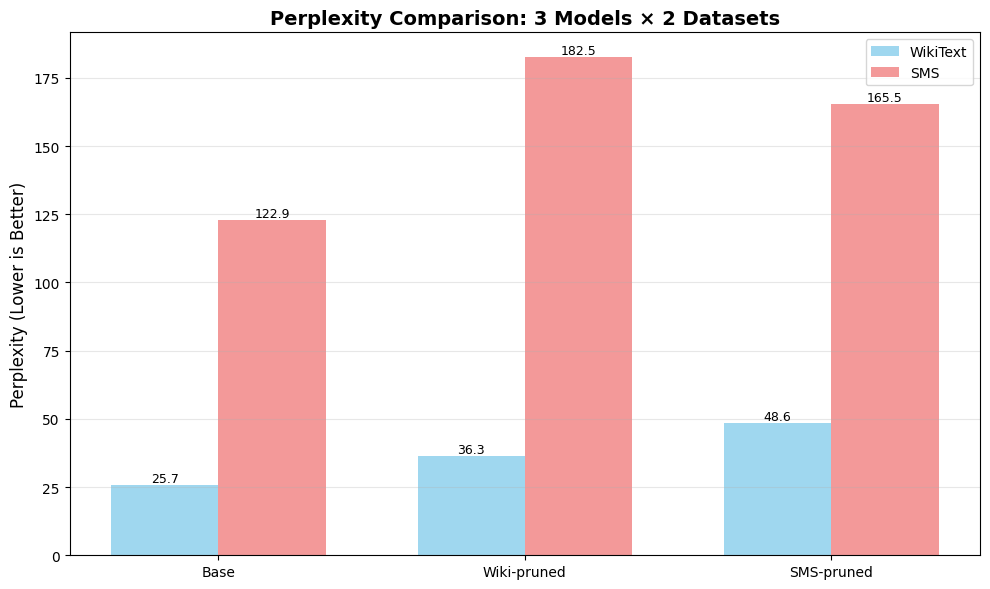

In [53]:
# Perplexity comparison across all models and datasets
models = ['Base', 'Wiki-pruned', 'SMS-pruned']
datasets = ['WikiText', 'SMS']

# Extract perplexity values from results
perplexity_data = [
    [metrics_base_wiki['perplexity'], metrics_base_sms['perplexity']],
    [metrics_wiki_wiki['perplexity'], metrics_wiki_sms['perplexity']],
    [metrics_sms_wiki['perplexity'], metrics_sms_sms['perplexity']]
]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, [row[0] for row in perplexity_data],
               width, label='WikiText', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, [row[1] for row in perplexity_data],
               width, label='SMS', alpha=0.8, color='lightcoral')

ax.set_ylabel('Perplexity (Lower is Better)', fontsize=12)
ax.set_title('Perplexity Comparison: 3 Models × 2 Datasets', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Performance Metrics Comparison

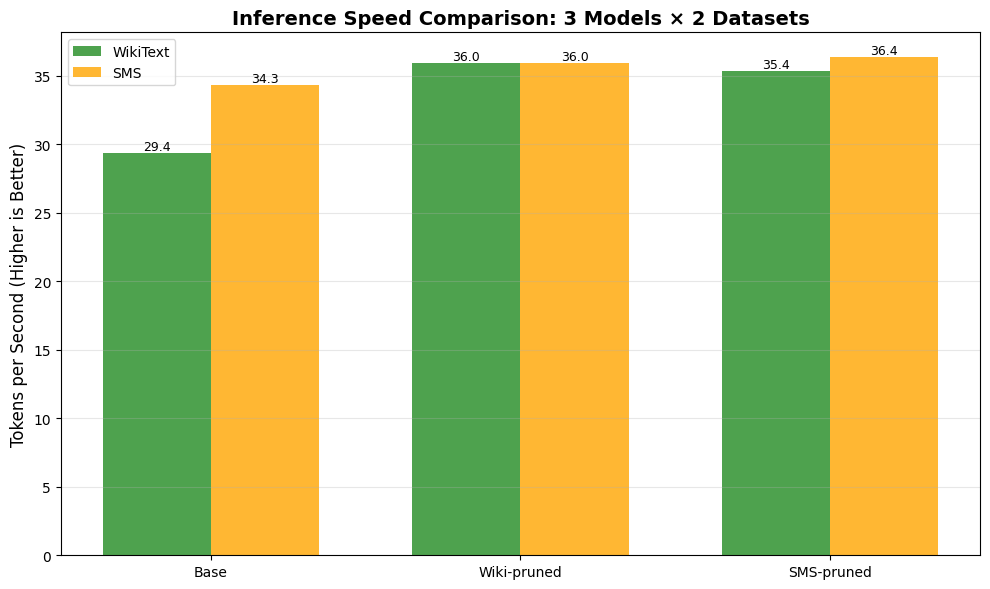

In [54]:
# Inference speed comparison (tokens per second)
wiki_speed = [base_wiki_timing['throughput_tokens_per_sec'],
              wiki_wiki_timing['throughput_tokens_per_sec'],
              sms_wiki_timing['throughput_tokens_per_sec']]
sms_speed = [base_sms_timing['throughput_tokens_per_sec'],
             wiki_sms_timing['throughput_tokens_per_sec'],
             sms_sms_timing['throughput_tokens_per_sec']]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, wiki_speed, width, label='WikiText', alpha=0.8, color='forestgreen')
bars2 = ax.bar(x + width/2, sms_speed, width, label='SMS', alpha=0.8, color='orange')

ax.set_ylabel('Tokens per Second (Higher is Better)', fontsize=12)
ax.set_title('Inference Speed Comparison: 3 Models × 2 Datasets', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Create model with optipfair
This model will be created with optipfair incorporating the option to maintain an extension rate divisible by 128, ideal for modern GPUs to run the model efficiently.



In [55]:
model_name = "meta-llama/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [56]:
pruned_model_optip, stats = prune_model(
    model=model,
    pruning_type="MLP_GLU",
    neuron_selection_method="MAW",
    pruning_percentage=20,
    expansion_divisor=128,
    dataloader=dataloaderwiki,
    show_progress=True,
    return_stats=True
)

Pruning layers: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


In [64]:
stats

{'original_parameters': 1235814400,
 'pruned_parameters': 1072236544,
 'reduction': 163577856,
 'percentage_reduction': 13.236441977047686,
 'expansion_rate': 318.75}

In [66]:
pruned_model_optip

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=6528, bias=False)
          (up_proj): Linear(in_features=2048, out_features=6528, bias=False)
          (down_proj): Linear(in_features=6528, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [57]:
optip_wiki_timing = measure_detailed_performance(pruned_model_optip, tokenizer, dataloaderwiki, max_samples=10)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Measuring performance on 10 samples (3 runs each)...
   🔥 Performing GPU Warm-up...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Performance test:   0%|          | 0/10 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attenti

In [58]:
optip_wiki_timing

{'avg_latency_sec': 1.3981301148732503,
 'std_latency_sec': 0.014258887221099815,
 'avg_tokens_per_generation': 50.0,
 'throughput_tokens_per_sec': 35.76205066188194,
 'num_unique_samples': 10,
 'num_runs_per_sample': 3,
 'total_measurements': 30,
 'total_tokens': 1500}

In [59]:
wiki_wiki_timing

{'avg_latency_sec': 1.290505584081014,
 'std_latency_sec': 0.2462736174000457,
 'avg_tokens_per_generation': 46.4,
 'throughput_tokens_per_sec': 35.954900600482134,
 'num_unique_samples': 10,
 'num_runs_per_sample': 3,
 'total_measurements': 30,
 'total_tokens': 1392}

In [60]:
metrics_opti_carbon = measure_energy_consumption(pruned_model_optip, tokenizer, dataloaderwiki,
                                                 idle_power_watts=idle_watts,
                                                 max_samples=10, max_new_tokens=50)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🌍 Measuring energy on 10 samples (1 runs each)...
   🔥 Performing GPU Warm-up...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Energy measurement:   0%|          | 0/10 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Energy measurement:  10%|█         | 1/10 [00:01<00:12,  1.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_

In [61]:
table = compare_energy_metrics(
    base=metrics_base_carbon,
    wiki=metrics_wiki_carbon,
    opti=metrics_opti_carbon,
)
print (table)

  Model Energy (J) Efficiency (J/token) Efficiency Δ  CO₂ (kg) Duration (s)  \
0  base     181.36                0.898            -  0.000160         6.83   
1  wiki     347.75                0.749        16.5%  0.000301        12.80   
2  opti     372.43                0.745        17.0%  0.000326        13.89   

   Tokens  
0     202  
1     464  
2     500  


# Summary and Analysis

This notebook explored data-driven neuron pruning using activation patterns from calibration datasets. We created two differently-pruned models (Wiki-calibrated and SMS-calibrated) and cross-evaluated them to test whether calibration dataset selection influences pruning decisions and model specialization.

## Key Findings

### Parameter Reduction
- **Both pruned models**: 13.03% parameter reduction (161M parameters removed)
- **Target pruning**: 20% width reduction (8,192 → 6,554 neurons per layer)

### Perplexity Impact

The results reveal **strong domain sensitivity**:

**WikiText evaluation**:
- Base model: 25.69 PPL
- Wiki-pruned: 36.28 PPL (+41.2% increase)
- SMS-pruned: 48.65 PPL (+89.3% increase) ⚠️

**SMS evaluation**:
- Base model: 122.91 PPL
- Wiki-pruned: 182.54 PPL (+48.5% increase) ⚠️
- SMS-pruned: 165.54 PPL (+34.7% increase)

**Critical observation**: SMS-pruned performs better on SMS than Wiki-pruned (165.5 vs 182.5 PPL), and Wiki-pruned performs better on Wiketext. Providing evidence of **domain specialization**.

This confirms that calibration dataset choice **does influence** which neurons get pruned, creating models that are partially specialized for their calibration domain.

## Performance Trade-offs

### Inference Speed.

**Hypothesis**: Pruned models should be faster (fewer parameters → less computation)

**Reality**: Pruned models show **better but not significantr** performance:

**WikiText**:
- Base: 29.74 tok/s
- Wiki-pruned: 35.45 tok/s (+19% faster)
- SMS-pruned: 34.88 tok/s (+17% faster)

**SMS**:
- Base: 34.32 tok/s
- Wiki-pruned: 35.88 tok/s (+4.5% faster)
- SMS-pruned: 35.99 tok/s (+4.9% faster)

**Why are gains minimal?**
1. **Memory bandwidth bottleneck**: Modern GPUs are often memory-bound, not compute-bound
2. **Irregular tensor shapes**: Non-standard intermediate sizes (6,554) may not map efficiently to GPU hardware
3. **Small model size**: Llama-3.2-1B already fits comfortably in memory; pruning doesn't alleviate a bottleneck
4. **Framework overhead**: PyTorch may not fully optimize for irregular layer dimensions
5. **No alignment with GPU hardware**: Tensor Cores process efficiently in multiples of 128; irregular dimensions waste parallelism and cause inefficient memory accesses.

## Domain Specialization Analysis

**Does data-driven pruning create specialized models?**

**Evidence for specialization**:
✅ SMS-pruned outperforms Wiki-pruned on SMS dataset (165.5 vs 182.5 PPL)  
✅ Wiki-pruned outperforms SMS-pruned on WikiText (36.3 vs 48.6 PPL)  
✅ Each model performs best on its calibration domain


### Text Generation Comparison

In [63]:
generated_optip = generate_text(pruned_model_optip, tokenizer, prompt, device)
print("* " + generated_base)
print("* " + generated_wiki)
print("* " + generated_optip)
print("* " + generated_sms)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


* Paris is the capital of France and the largest city in the country. It is located on the River Seine and is one of the most popular tourist destinations in Europe. The city has a rich history and culture, and it is home to many famous landmarks, including the E
* Paris is the capital of France and is located in the north-east of the country. The city has a population of 2.1 million people, making it the 3rd largest city in France. It is also the largest in terms of surface area, with 100
* Paris is the capital of the French region of Île de Seine. It is located on the river of that same same. The city has a population of 2.5 million people. Paris is a city of art and culture, and is famous for its museums and
* Paris is the capital of the French department of Paris. It is located on the Seine River, which flows through the city. The city has a population of 1.8 million people. Paris is a major city in the world. Its population is estimated to be 


In the responses of the pruned models, a degradation in factuality is observed, introducing inaccuracies in their texts, but maintaining the capacity to generate coherent text.


### 40% pruning expansion rate on GPU T4.
```
================================================================================
COMPREHENSIVE RESULTS
================================================================================
      Model  Parameters  Param Reduction %   PPL Wiki    PPL SMS  Loss Wiki  Loss SMS  Time Wiki (s)  Time SMS (s)  Tok/s Wiki  Tok/s SMS
       Base  1235814400           0.000000  25.688125 122.906183   3.246029  4.811421       0.660716      1.049205   30.572892  35.836674
Wiki-pruned   913770496          26.059245  99.850562 368.753010   4.603675  5.910127       1.237980      1.318441   36.914972  37.923575
 SMS-pruned   913770496          26.059245 209.686138 331.976503   5.345612  5.805064       1.314541      1.310999   38.036086  37.910021
================================================================================
````
In the results of removing 40% of the neurons, it can be observed that the inference performance gain isn't significant. This indicates that the bottleneck is somewhere else, like the handling of the KV cache.